## Le but de notre projet est d'implémenter le ridge de façon paralléliser 

In [1]:
# Importation des librairies
import numpy as np
import matplotlib.pyplot as plt
import time

## 1) Générer des données sparse pour une régresssion lineaire

In [26]:
from simulateur_donnees import *

In [29]:
d = 50              # nombre de features
n = 10000           # nombre d'échantillons

A, b, true_coef = get_data(d, n)

print('La dimension de A est :', A.shape ,'\nLa dimension de b est :', b.shape)

La dimension de A est : (10000, 50) 
La dimension de b est : (10000,)


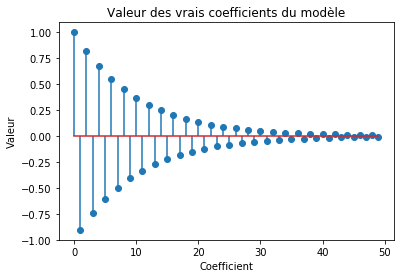

In [28]:
plt.stem(true_coef, use_line_collection=True)
plt.xlabel('Coefficient')
plt.ylabel('Valeur')
plt.title('Valeur des vrais coefficients du modèle')
plt.show()

## La régression Ridge

On souhaite minimiser la fonction suivante:
$$ \forall x \in \mathbb{R}^d, \, \,  f(x) = \frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2 $$
où $A = (a_1^\top, \dots ,  a_n^\top)^\top \in \mathbb{R}^{nxd}$, $b \in \mathbb{R}^n$  et  $\ell(z,b) = \frac 12 (z - b)^2$.

### L'algorithme de la Descente du Gradient Stochastique

Pour résoudre le problème de la régression de Ridge, on utilise la méthode de la Descente du Gradient Stochastique.

On souhaite d'abord tester les performances de cet algorithme sans parallélisation. 

In [30]:
from SGD_non_para import *

Mesurons le temps d'execution de l'algorithme pour n=1000, d=50 et une taille de batch=50

In [31]:
start = time.time()
w_min, w_iter = sgd(x_init=np.ones(len(true_coef)), n=n, n_epochs=300, size_batch=50,
                    A=A, b=b, lbda=0.1, step=0.1)
end = time.time()

print('''Le temps d'exécution du SGD pour n=1000 et d=50 est : ''', end-start,'s')

149.28062534332275 s


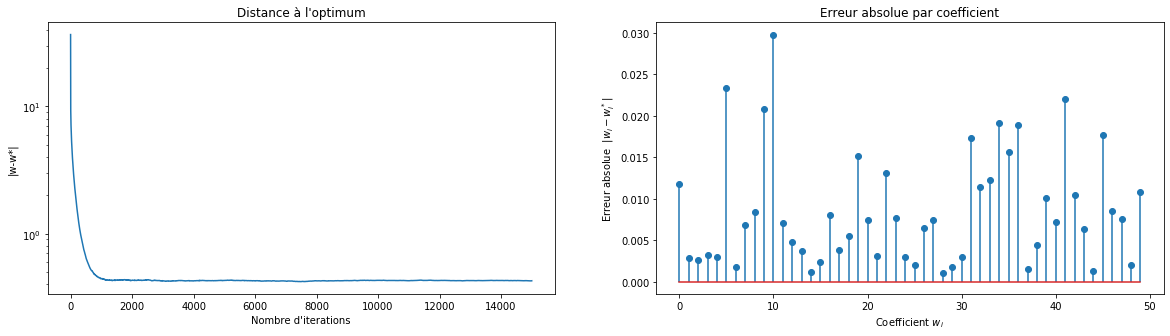

L'erreur absolue moyenne (MAE) est:  0.008527912491710515


In [44]:
errors = [sum(abs(w - true_coef)) for w in w_iter]


# Distance à l'optimum
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.semilogy(errors)
plt.xlabel('''Nombre d'iterations''')
plt.ylabel('|w-w*|')
plt.title('''Distance à l'optimum''')

# Erreur absolue par coefficient
plt.subplot(1,2,2)
plt.stem(abs(w_min - true_coef), use_line_collection=True)
plt.xlabel('Coefficient $w_i$')
plt.ylabel('Erreur absolue  $|w_i-w^*_i|$')
plt.title('Erreur absolue par coefficient')
plt.show()

print('''L'erreur absolue moyenne (MAE) est: ''', sum(abs(w_min - true_coef)) / len(w_min)) 

In [45]:
from SGD_para import *

In [47]:
debut = time.time()

if __name__=="__main__":
    results = sgd_para_run(x_init=np.ones(len(x_model_truth)), n=n, n_epochs=300, size_batch=50,
                     A=A, b=b, lbda=0.1)
    w_min = (results[0][0] + results[1][0]) / 2
    w_iter = (np.array(results[0][1]) + np.array(results[1][1])) / 2
fin = time.time()
print(fin-debut,'s')

78.10525107383728 s


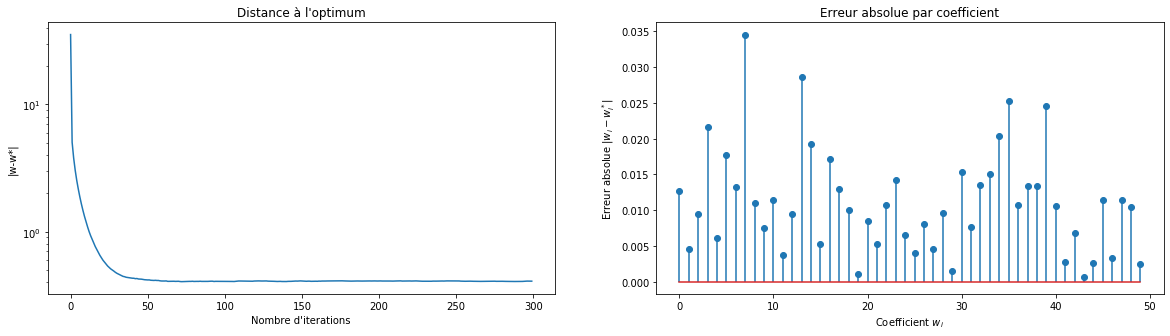

L'erreur absolue moyenne (MAE) est:  0.008174276458252085


In [55]:
errors = [sum(abs(w - true_coef)) for w in w_iter]


# Distance à l'optimum
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.semilogy(errors)
plt.xlabel('''Nombre d'iterations''')
plt.ylabel('|w-w*|')
plt.title('''Distance à l'optimum''')


# Erreur absolue par coefficient
plt.subplot(1,2,2)
plt.stem(abs(w_solu - x_model_truth), use_line_collection=True)
plt.xlabel('Coefficient $w_i$')
plt.ylabel('Erreur absolue $|w_i-w^*_i|$')
plt.title('Erreur absolue par coefficient')
plt.show()

print('''L'erreur absolue moyenne (MAE) est: ''', sum(abs(w_min - true_coef)) / len(w_min)) 

Grâce à la parallélisation, on arrive à diviser **le temps d'exécution** de la Descente du Gradient Stochastique par **deux** tout en ayant **une erreur absolue moyenne moindre**.

### Effet de la taille de l'échantillon n

In [21]:
# fonction qui simule des données pour différente

def simulateur_donnees(n,d):
    
    """Cette fonction simule des données pour différentes tailles de l'échantillon n """
    
    idx = np.arange(d)
    x_model_truth = (-1)**idx * np.exp(-idx / 10.) # Valeur des vrais paramètres 
    A, b = simu_linreg(x_model_truth, n, std=1., corr=0.5)
    return x_model_truth, A, b


In [49]:
# On simule plusieurs jeux de données où la taille n de l'échantillon varie

A_n, b_n, true_coef_n = [], [], []

n_sample = [100, 1000, 2000, 5000, 10000, 15000, 20000, 30000, 40000, 50000]

for sample in n_sample:
    true_coef, A_sample, b_sample = simulateur_donnees(n=sample, d=50)
    A_n.append(A_sample)
    b_n.append(b_sample)
    true_coef_n.append(true_coef)

In [56]:
# On l'évolution du temps d'executions pour différentes valeurs de n
tps_non_paras, w_min_non_paras = [],[]
tps_paras, w_min_paras = [], []

for i in range(len(n_sample)):
    
    print(i, 'ème itération \n******************')
    n = n_sample[i]
    true_coef, A, b = true_coef_n[i], A_n[i], b_n[i]
    iis = np.random.randint(0, n, n * 100)
    
    start = time.time()
    w_min_non_para, _ = sgd(x_init=np.ones(len(true_coef)), n=n, n_epochs=100, A=A, b=b, lbda=0.1, step=0.1,size_batch=10)
    w_min_non_paras.append(w_min_non_para)
    end = time.time()
    tps_non_paras.append(end-start)
    
    start = time.time()
    results = sgd_para_run(x_init=np.ones(len(true_coef)), n=n, n_epochs=100, size_batch=10, A=A, b=b, lbda=0.1)
    w_min_para = (results[0][0] + results[1][0]) / 2
    w_min_paras.append(w_min_para)
    end = time.time()
    tps_paras.append(end-start)

0 ème itération 
******************
1 ème itération 
******************
2 ème itération 
******************
3 ème itération 
******************
4 ème itération 
******************
5 ème itération 
******************
6 ème itération 
******************
7 ème itération 
******************
8 ème itération 
******************
9 ème itération 
******************


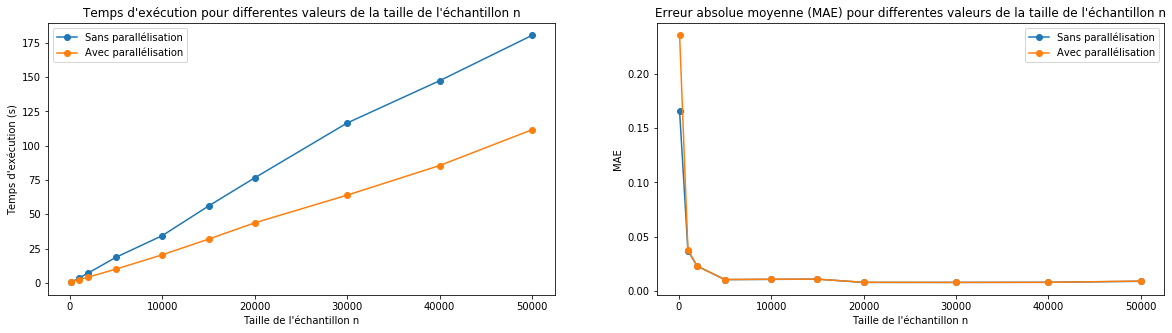

In [57]:
# On compare les perfomances du SGD dans le cas parallélisé et non-parallélisé

mae_non_para = [sum(abs(w - true_coef)) / len(w) for w in w_min_non_paras]
mae_para = [sum(abs(w - true_coef)) / len(w) for w in w_min_paras]


plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(n_sample, tps_non_paras, 'o-')
plt.plot(n_sample, tps_paras, 'o-')
plt.xlabel('''Taille de l'échantillon n''')
plt.ylabel('''Temps d'exécution (s)''')
plt.legend(('Sans parallélisation', 'Avec parallélisation'),loc='best')
plt.title('''Temps d'exécution pour differentes valeurs de la taille de l'échantillon n''')

plt.subplot(1,2,2)
plt.plot(n_sample, mae_non_para, 'o-')
plt.plot(n_sample, mae_para, 'o-')
plt.xlabel('''Taille de l'échantillon n''')
plt.ylabel('''MAE''')
plt.legend(('Sans parallélisation', 'Avec parallélisation'),loc='best')
plt.title('''Erreur absolue moyenne (MAE) pour differentes valeurs de la taille de l'échantillon n''')

plt.show()


- La parallélisation diminue considérablement le temps d'exécution de l'algorithme. En particulier, on voit que plus le taille de l'échantillon n est grande, plus la diminution du temps d'exécution est importante.

- La parallélisation est aussi performante en termes de précision puisque l'erreur moyenne absolue (MAE) de la Descente du Gradient Stochastique parallélisée diminue et coincide de plus en plus avec l'erreur moyenne absolue (MAE) du cas non-parallélisé quand la taille de l'échantillon n augmente.